In [1]:
import numpy as np
import seaborn
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

2023-06-08 15:03:53.966765: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 15:03:54.006615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-08 15:03:54.007159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-08 15:03:54.641236: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(42)
set_seed(42)

## Классификация

Датасет - churn

In [3]:
X = pd.read_csv("churn-x.csv")
y = pd.read_csv("churn-y.csv")
y = y.drop(columns=['Unnamed: 0'])
y = y['churn']
y = y.values

In [4]:
X = X.drop(columns=['Unnamed: 0'])
X = np.array(X)

In [5]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# + сет для валидации
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

# Преобразование целевых меток в one-hot кодировку
encoder = OneHotEncoder(categories='auto')
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.transform(y_test.reshape(-1, 1)).toarray()
y_val = encoder.transform(y_val.reshape(-1, 1)).toarray()

print(f"Train: {X_train.shape[0]:6d}")
print(f"Test:  {X_test.shape[0]:6d}")
print(f"Val:   {X_val.shape[0]:6d}")

Train:   4609
Test:     922
Val:      231


### Keras

In [6]:
# Создание модели нейронной сети
model = Sequential([
    Dense(128, activation='elu', input_shape=(25,)),
    Dense(64, activation='elu'),
    Dense(32, activation='elu'),
    Dense(16, activation='elu'),
    Dense(8, activation='elu'),    
    Dense(2, activation='softmax')
])

model.summary()
# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3328      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 14,346
Trainable params: 14,346
Non-traina

2023-06-08 15:03:55.600030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-08 15:03:55.600752: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# Обучение модели
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=300, batch_size=X_train.size, verbose=0)

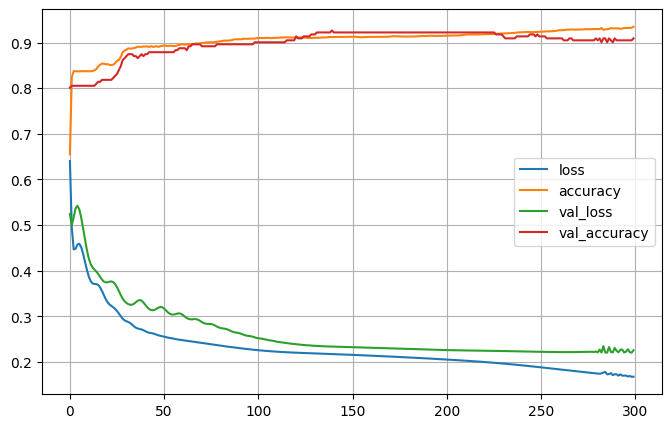

In [8]:
def history_plot(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

history_plot(history)

In [9]:
# Оценка модели на обучающей выборке
loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
print(f'Train loss: {loss:.4f}')
print(f'Train accuracy: {accuracy:.4f}')

Train loss: 0.1676
Train accuracy: 0.9325


In [10]:
# Оценка модели на тестовой выборке
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Test loss: 0.1903
Test accuracy: 0.9262


In [11]:
# Оценка модели на валидации 
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f'Val loss: {loss:.4f}')
print(f'Val accuracy: {accuracy:.4f}')

Val loss: 0.2259
Val accuracy: 0.9091


### Pytorch

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary 
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Создание пользовательского датасета PyTorch
class ChurnDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)

In [15]:
# Создание модели нейронной сети
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [16]:
# Создание экземпляров датасета и загрузчиков данных
train_dataset = ChurnDataset(X_train, y_train)
test_dataset = ChurnDataset(X_test, y_test)
val_dataset = ChurnDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_laoder = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [17]:
# Создание модели и оптимизатора
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()    

# Оценка модели на тестовой выборке
model.eval()
total_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_loss += criterion(outputs, labels).item()
        total += labels.size(0)
        correct += (predicted == torch.max(labels, 1)[1]).sum().item()                
        

accuracy = correct / total
avg_loss = total_loss / len(test_loader)
print(f'Test loss: {avg_loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


Test loss: 0.2196
Test accuracy: 0.9317


In [18]:
# Функция для получения предсказанных меток
def get_predicted_labels(outputs):
    _, predicted = torch.max(outputs.data, 1)
    return predicted.numpy()

# Функция для получения фактических меток
def get_true_labels(labels):
    return np.argmax(labels, axis=1)

# Оценка модели на тестовой выборке
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted_labels.extend(get_predicted_labels(outputs))
        true_labels.extend(get_true_labels(labels.numpy()))

# Отчет о классификации
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.79      0.79       146
           1       0.96      0.96      0.96       776

    accuracy                           0.93       922
   macro avg       0.87      0.88      0.87       922
weighted avg       0.93      0.93      0.93       922



In [19]:
model.to(device)
summary(model, (25,))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,664
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 2]              66
           Softmax-6                    [-1, 2]               0
Total params: 3,810
Trainable params: 3,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------
Net(
  (fc1): Linear(in_features=25, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, b

## Регрессия

Датасет - house prices

In [61]:
from sklearn.datasets import fetch_california_housing
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import QuantileTransformer

In [89]:
X = pd.read_csv("../house-prices/train-house-prices-x.csv")
y = pd.read_csv("../house-prices/train-house-prices-y.csv")
X = X.drop(columns=['Unnamed: 0'])
X = X.values
y = y['Sold Price'].values

In [90]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### Keras

In [91]:
from sklearn.metrics import r2_score

# Создание модели нейронной сети
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_logarithmic_error','mean_squared_error'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 128)               1664      
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dense_44 (Dense)            (None, 64)                4160      
                                                                 
 dense_45 (Dense)            (None, 32)                2080      
                                                                 
 dense_46 (Dense)            (None, 32)                1056      
                                                                 
 dense_47 (Dense)            (None, 1)                 33        
                                                                 
Total params: 17,249
Trainable params: 17,249
Non-trai

In [92]:
# Обучение модели
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=1000, batch_size=X_train.shape[0], verbose=0)

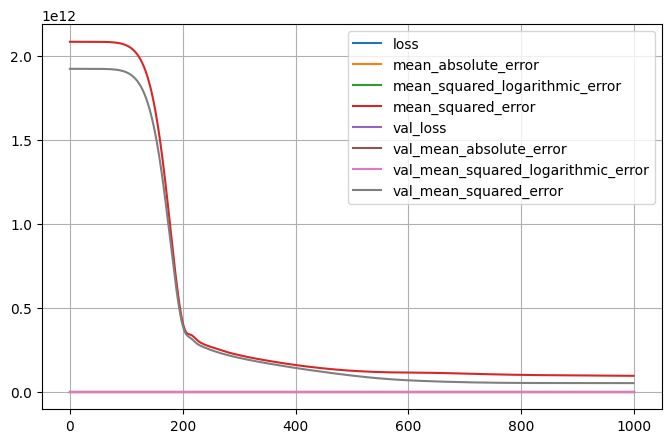

In [93]:
history_plot(history)

In [94]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

102/102 [==============================] - 0s 739us/step


In [95]:
# Оценка модели 
loss, mae, msle, mse = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss:.4f}')
print(f'Test MAE: {mae:.4f}')
print(f'Test MSLE: {msle:.4f}')
print(f'Test MSE: {mse:.4f}')
print(f'Test R2: {r2:.4f}')

Test loss: 97423.5391
Test MAE: 97423.5391
Test MSLE: 0.0563
Test MSE: 54222573568.0000
Test R2: 0.9286


### Pytorch

In [96]:
# Преобразование данных в тензоры PyTorch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [97]:
# Определение модели нейронной сети
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


model = RegressionModel(X_train.shape[1])

# Определение функции потерь и оптимизатора
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Обучение модели
num_epochs = 2000
batch_size = X_train.shape[0] 
for epoch in range(num_epochs):    
    indices = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_inputs = X_train[batch_indices]
        batch_targets = y_train[batch_indices]

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/2000], Loss: 334242.6250
Epoch [200/2000], Loss: 156523.9062
Epoch [300/2000], Loss: 113014.9531
Epoch [400/2000], Loss: 110679.6953
Epoch [500/2000], Loss: 110069.5469
Epoch [600/2000], Loss: 108855.4141
Epoch [700/2000], Loss: 107653.0312
Epoch [800/2000], Loss: 106755.8125
Epoch [900/2000], Loss: 105954.6016
Epoch [1000/2000], Loss: 105280.6875
Epoch [1100/2000], Loss: 104778.1016
Epoch [1200/2000], Loss: 104368.1953
Epoch [1300/2000], Loss: 104065.8594
Epoch [1400/2000], Loss: 103822.9141
Epoch [1500/2000], Loss: 103483.4766
Epoch [1600/2000], Loss: 103233.2344
Epoch [1700/2000], Loss: 103045.7109
Epoch [1800/2000], Loss: 102898.7656
Epoch [1900/2000], Loss: 102716.7734
Epoch [2000/2000], Loss: 102650.6328


In [98]:
# Оценка модели на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    r2 = r2_score(y_test, test_outputs)
print(f'Test loss (MAE): {test_loss.item():.4f}')
print(f'Test R2: {r2:.4f}')

Test loss (MAE): 96353.8281
Test R2: 0.9321
